<a href="https://colab.research.google.com/github/astrodeepnet/vae_mpoe/blob/main/mm_vae_toymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

bands = [(0, 15), (15, 30), (30, 50), (50, 70), (70, 85), (85, 100)]

In [2]:
class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [3]:
def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
#    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

In [4]:
def generate_spectrum(n_bins=100, n_peaks=3, noise_level=0.05, pmin=-1, pmax=1,):
    x = np.linspace(0, 1, n_bins)  # Avoid zero to prevent division by zero in power law
    spectrum = np.zeros_like(x)

    # Add power law component
    power_law_exponent = np.random.uniform(pmin, pmax)
    spectrum += np.power(x+0.3, power_law_exponent)

    # Add Gaussian peaks
    n = np.random.randint(1,n_peaks+1)
    for _ in range(n):
        amplitude = np.random.uniform(0.1, 1.0)
        mean = np.random.uniform(0.2, 0.8)
        std_dev = np.random.uniform(0.01, 0.1)
        amplitude = amplitude * spectrum[int(mean*n_bins)]
        spectrum += amplitude * np.exp(-0.5 * ((x - mean) / std_dev)**2)

    # Add noise
    noise = np.random.normal(scale=noise_level, size=n_bins)
    spectrum += noise

    return x, spectrum

# Integrate the spectrum over given band passes
def integrate_band_passes(spectrum, band_edges):
    integrals = []
    for (start, end) in band_edges:
        band_val = np.nansum(spectrum[start:end]) / (end-start+1)
        integrals.append(band_val)
    return np.array(integrals)

# Generate a dataset
def generate_dataset(n_samples=1000, n_bins=100, n_peaks=3, noise_level=0.05, pmin=-1, pmax=1, band_edges=None):
    if band_edges is None:
        # Define 6 band pass edges (as indices for simplicity)
        band_edges = bands

    spectra = []
    integrals = []
    for _ in range(n_samples):
        _, spectrum = generate_spectrum(n_bins=n_bins, n_peaks=n_peaks, noise_level=noise_level, pmin=pmin, pmax=pmax)
        spectrum /= np.max(spectrum)
        spectra.append(spectrum)
        integrals.append(integrate_band_passes(spectrum, band_edges))

    spectra = np.array(spectra, dtype=np.float32)
    integrals = np.array(integrals, dtype=np.float32)

    return spectra, integrals

# Normalize the spectra and integrals
def normalize(data):
    h = np.max(data, axis=1)[:,None]
    l = np.min(data, axis=1)[:,None]
    return data/h


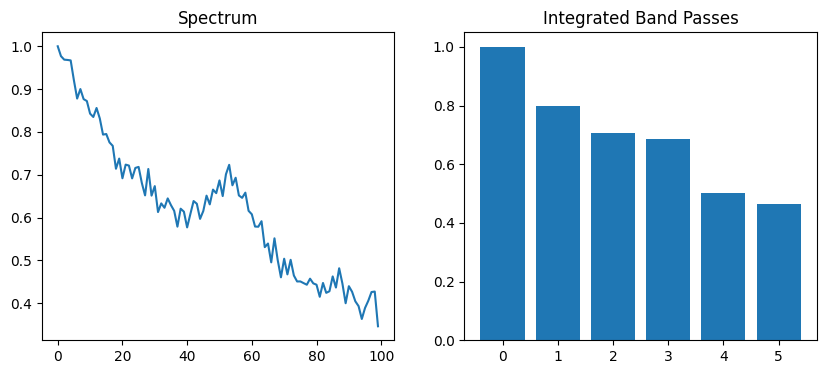

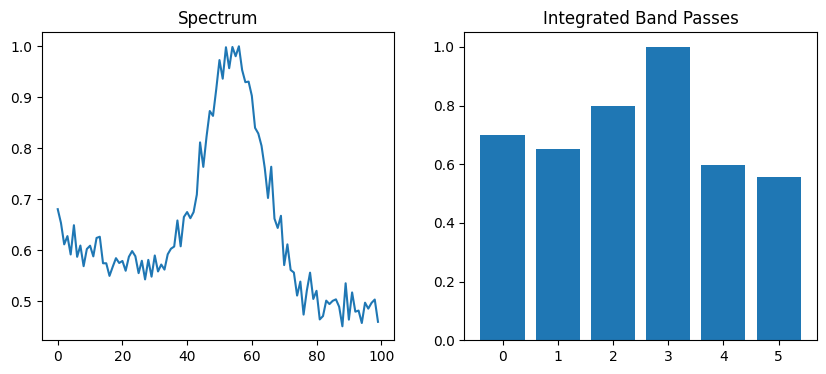

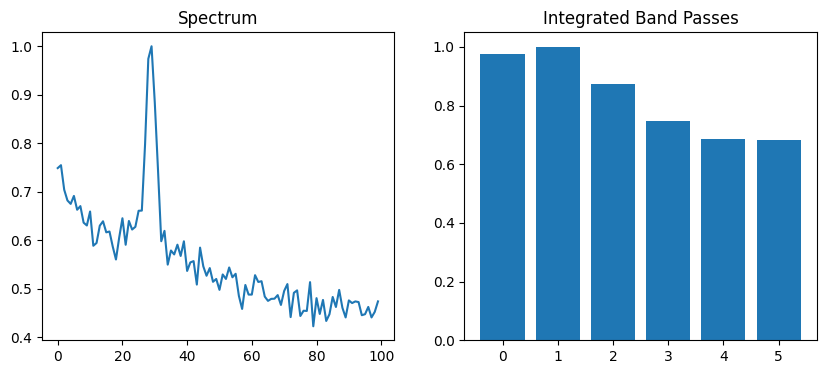

In [5]:
n_samples = 100000
n_bins = 100
n_peaks = 1
spectra, integrals = generate_dataset(n_samples, n_bins, n_peaks)
#spectra, integrals = generate_dataset(n_samples, n_bins, 1, noise_level=0, pmin=0)

# Normalize data
spectra = normalize(spectra)
integrals = normalize(integrals)

# Visualize some examples
for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(spectra[i])
    plt.title('Spectrum')
    plt.subplot(1, 2, 2)
    plt.bar(range(len(integrals[i])), integrals[i])
    plt.title('Integrated Band Passes')
    plt.show()

In [6]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = build_dense_decoder_sed(latent_dim,input_dim)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                    keras.losses.mean_squared_error(data, reconstruction),
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction

In [7]:
bpvae = BandPassVAE(6,3, beta=0.0001)

In [8]:
bpvae.compile(optimizer=keras.optimizers.Adam())

In [9]:
h=bpvae.fit(integrals, epochs=200, batch_size=128, validation_split=0.2)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 6))
  warnings.warn(msg)


617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 7.8944 - loss: 0.0224 - reconstruction_loss: 0.0217

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - kl_loss: 7.9196 - loss: 0.0222 - reconstruction_loss: 0.0214 - val_kl_loss: 9.4986 - val_loss: 0.0119 - val_reconstruction_loss: 0.0109
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 8.0055 - loss: 0.0068 - reconstruction_loss: 0.0060 - val_kl_loss: 7.0754 - val_loss: 0.0088 - val_reconstruction_loss: 0.0081
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 6.9278 - loss: 0.0059 - reconstruction_loss: 0.0052 - val_kl_loss: 6.7928 - val_loss: 0.0082 - val_reconstruction_loss: 0.0075
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 6.7000 - loss: 0.0056 - reconstruction_loss: 0.0050 - val_kl_loss: 6.5225 - val_loss: 0.0073 - val_reconstruction_loss: 0.0066
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 6.5875 - loss: 0.0054 - reconstruction_loss: 0.0047 - val_kl_loss: 6.4914 - val_loss: 0.0073 - val_reconstruction_loss: 0.0066
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl

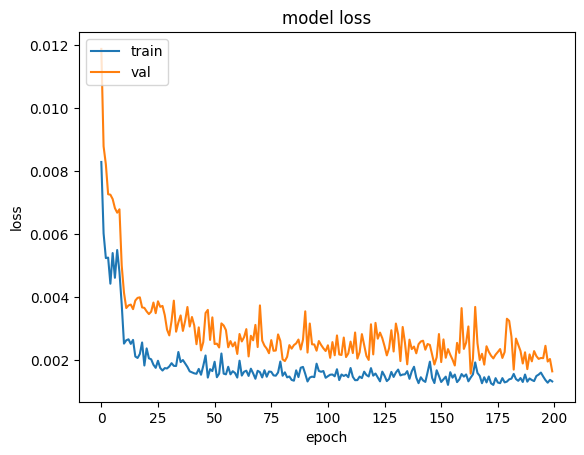

In [10]:

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

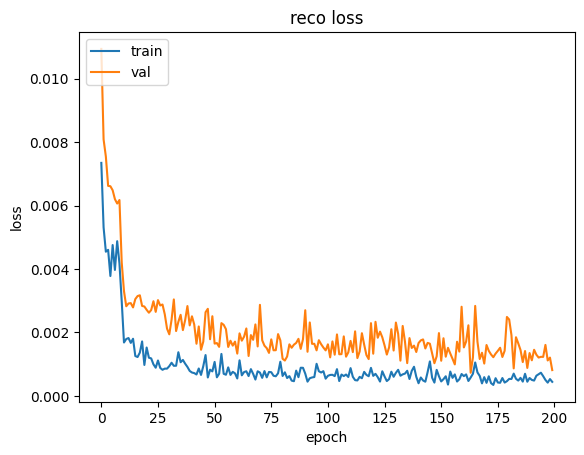

In [11]:
plt.plot(h.history['reconstruction_loss'])
plt.plot(h.history['val_reconstruction_loss'])
plt.title('reco loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
bands_mean = []
for b in bands:
   bands_mean.append(0.5*(b[0]+b[1]))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 6))
  warnings.warn(msg)


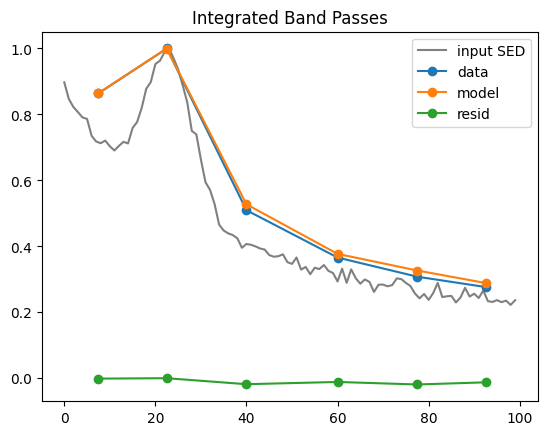

In [13]:

ii=1900
s = bpvae(np.reshape(integrals[ii],(1,6)))
s = np.reshape(s[0].numpy(),(6,))
resid = integrals[ii] - s
pos_sed = np.linspace(0, 5, len(spectra[ii]))
plt.plot(spectra[ii], label='input SED', color='grey')
plt.plot(bands_mean, integrals[ii], marker='o', label='data')
plt.plot(bands_mean, s, marker='o', label='model')
plt.plot(bands_mean, resid, marker='o', label='resid')
plt.legend()

plt.title('Integrated Band Passes')
plt.show()

In [14]:
def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_decoder_sp(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(64, activation='relu')(latent_inputs)
    x = layers.Dense(128*(output_shape[0]//8), activation='relu')(x)
#    x = layers.Dense(128 * (output_shape[0]//8), activation='relu')(x)
    x = layers.Reshape((output_shape[0]//8,128))(x)
    x = layers.Conv1DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    l = x.shape[1]
    p1 = (output_shape[0]//4-l)//2
    p2 = output_shape[0]//4 -l - p1
    if p1>0 or p2>0:
        x = layers.ZeroPadding1D((p1,p2))(x)
    x = layers.Conv1DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    l = x.shape[1]
    p1 = (output_shape[0]//2-l)//2
    p2 = output_shape[0]//2 -l - p1
    if p1>0 or p2>0:
        x = layers.ZeroPadding1D((p1,p2))(x)
    outputs = layers.Conv1DTranspose(output_shape[1], 3,activation='sigmoid', strides=2, padding='same', name="lastconv")(x)

    decoder = keras.Model(latent_inputs, outputs, name='cnn_decoder')
    return decoder


def build_dense_encoder_sp_branch(input_shape):
    encoder_input = keras.Input(shape=input_shape)
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)

    return keras.Model(encoder_input, x, name='dense_encoder')

def build_dense_decoder_sp(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(output_shape[0] * output_shape[1], activation='sigmoid')(x)
    outputs = layers.Reshape(output_shape)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder

build_cnn_encoder_branch = build_dense_encoder_sp_branch
build_cnn_decoder = build_dense_decoder_sp

class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_cnn_encoder_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_cnn_decoder(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction[:, :, 0])/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction[:, :, 0])/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [15]:
spvae = SpectraVAE(100, 10, beta=0.0001)
spvae.compile(optimizer=keras.optimizers.Adam())

In [16]:
hsp=spvae.fit(spectra, epochs=70, batch_size=128, validation_split=0.2)

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 21.4940 - loss: 0.0262 - reconstruction_loss: 0.0240

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(None, 100))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - kl_loss: 21.4926 - loss: 0.0261 - reconstruction_loss: 0.0240 - val_kl_loss: 20.6070 - val_loss: 0.0144 - val_reconstruction_loss: 0.0124
Epoch 2/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - kl_loss: 21.2459 - loss: 0.0141 - reconstruction_loss: 0.0120 - val_kl_loss: 21.7631 - val_loss: 0.0113 - val_reconstruction_loss: 0.0091
Epoch 3/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - kl_loss: 20.1828 - loss: 0.0120 - reconstruction_loss: 0.0099 - val_kl_loss: 19.7521 - val_loss: 0.0098 - val_reconstruction_loss: 0.0078
Epoch 4/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - kl_loss: 19.0230 - loss: 0.0109 - reconstruction_loss: 0.0090 - val_kl_loss: 18.6106 - val_loss: 0.0097 - val_reconstruction_loss: 0.0078
Epoch 5/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - kl_loss: 19.6414 - loss: 0.0092 - reconstruction_loss: 0.0072 - val_kl_loss: 20.5075 - val_loss: 0.0070 - val_reconstruction_loss: 0.0049
Epoch 6/70
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 

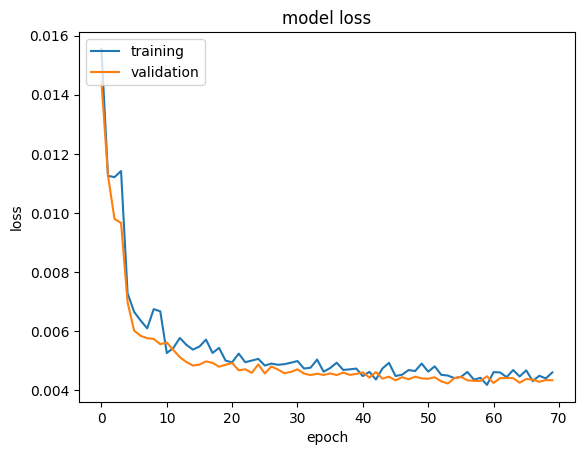

In [17]:
plt.plot(hsp.history['loss'])
plt.plot(hsp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(1, 100, 1))
  warnings.warn(msg)


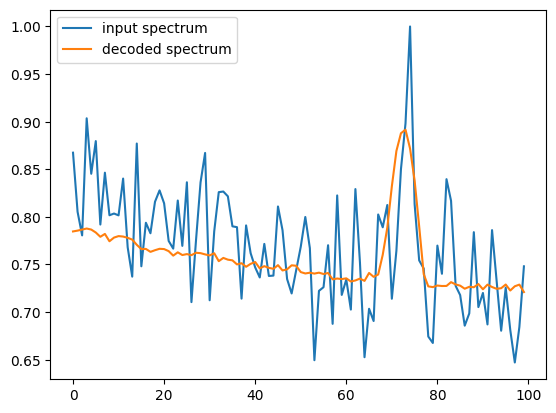

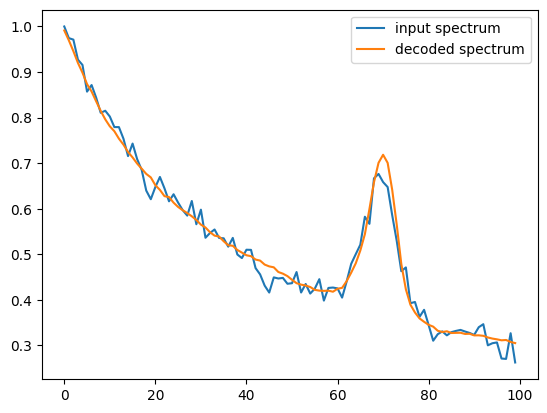

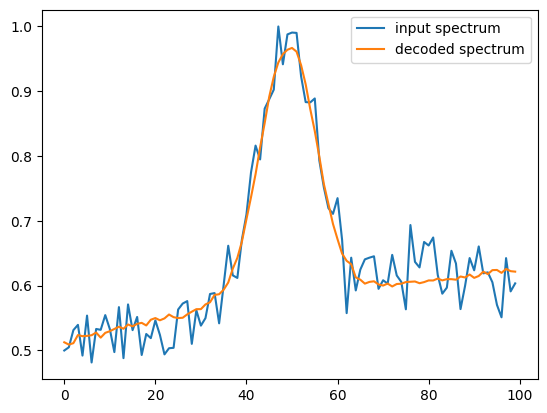

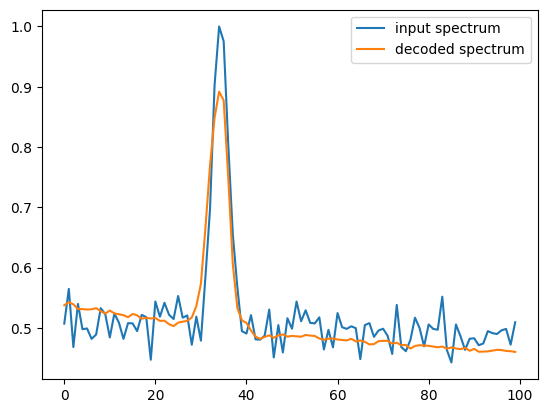

In [18]:
ii=1026
for ii in [1026, 1027, 1028, 1029]:
    plt.plot(spectra[ii], label="input spectrum")
    s = spvae(np.reshape(spectra[ii],(1,100,1)))
    s = np.reshape(s[0].numpy(),(100,))
    plt.plot(s, label="decoded spectrum")
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_9']
Received: inputs=Tensor(shape=(10000, 100, 1))
  warnings.warn(msg)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.02782989, -0.02730241, -0.02677492, -0.02624743, -0.02571995,
        -0.02519246, -0.02466497, -0.02413749, -0.02361   , -0.02308252,
        -0.02255503, -0.02202754, -0.02150006, -0.02097257, -0.02044508,
        -0.0199176 , -0.01939011, -0.01886262, -0.01833514, -0.01780765,
        -0.01728016, -0.01675268, -0.01622519, -0.01569771, -0.01517022,
        -0.01464273, -0.01411525, -0.01358776, -0.01306027, -0.01253279,
        -0.0120053 , -0.01147781, -0.01095033, -0.01042284, -0.00989535,
        -0.00936787, -0.00884038, -0.0083129 , -0.00778541, -0.00725792,
        -0.00673044, -0.00620295, -0.00567546, -0.00514798, -0.00462049,
        -0.004093  , -0.00356552, -0.00303803, -0.00251054, -0.00198306,
        -0.00145557, 

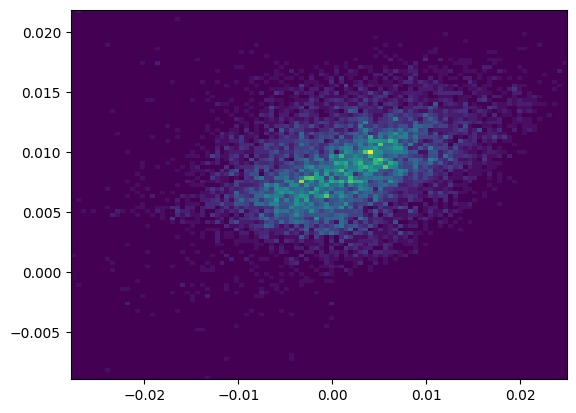

In [19]:
r = spvae.apply(np.reshape(spectra[:10000],(10000,100,1)))
plt.hist2d(r[0][:,1],r[0][:,2], bins=100)

In [20]:
class ProductOfExperts(layers.Layer):
    def __init__(self, **kwargs):
        super(ProductOfExperts, self).__init__(**kwargs)

    def call(self, inputs):
        # inputs is a list of [mu1, log_var1, mu2, log_var2, ...]
        mus = inputs[::2]
        log_vars = inputs[1::2]

        # Filter out None values
        # currently not used since PoE not called when only one modality
        mus = [mu for mu in mus if mu is not None]
        log_vars = [log_var for log_var in log_vars if log_var is not None]

        if len(mus) == 0 or len(log_vars) == 0:
            raise ValueError("At least one mu and log_var must be provided")

        precision_terms = [ops.exp(-log_var) for log_var in log_vars]
        precisions = ops.sum(precision_terms, axis=0)
        mus_weighted = [mu * ops.exp(-log_var) for mu, log_var in zip(mus, log_vars)]
        mu_poe = ops.sum(mus_weighted, axis=0) / precisions
        log_var_poe = ops.log(1.0 / precisions)

        return [mu_poe, log_var_poe]

    def compute_output_shape(self, input_shape):
        return [input_shape[0], input_shape[1]]


class MixtureOfExperts(layers.Layer):
    def __init__(self, num_experts, latent_dim, **kwargs):
        super(MixtureOfExperts, self).__init__(**kwargs)
        self.num_experts = num_experts
        self.latent_dim = latent_dim

    def build(self, input_shape):
        self.gating_network = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(self.num_experts, activation='softmax')
        ])

    def call(self, inputs):
        # inputs is a list of [mu1, log_var1, mu2, log_var2, ..., muN, log_varN]
        mus = inputs[::2]
        log_vars = inputs[1::2]

        # Concatenate mu and log_var to pass through the gating network
        combined_inputs = tf.concat(inputs, axis=-1)
        weights = self.gating_network(combined_inputs)

        # Calculate the weighted sum of means and variances
        mu_moe = tf.reduce_sum([w * mu for w, mu in zip(tf.split(weights, self.num_experts, axis=-1), mus)], axis=0)
        log_var_moe = tf.reduce_sum([w * log_var for w, log_var in zip(tf.split(weights, self.num_experts, axis=-1), log_vars)], axis=0)

        return [mu_moe, log_var_moe]

    def compute_output_shape(self, input_shape):
        return [input_shape[0], input_shape[1]]

In [58]:
class MMVAE(keras.Model):
    def __init__(self, input_bp_dim, input_sp_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)

        self.dim_a = input_bp_dim
        self.dim_b = input_sp_dim

        self.encoder_branch_a = build_dense_encoder_sed_branch((input_bp_dim,))
        self.encoder_branch_b = build_dense_encoder_sp_branch((input_sp_dim,1))

        self.z_mean_a = layers.Dense(latent_dim, name='z_mean_a')(self.encoder_branch_a.output)
        self.z_log_var_a = layers.Dense(latent_dim, name='z_log_var_a')(self.encoder_branch_a.output)
        self.z_a = Sampling()([self.z_mean_a, self.z_log_var_a])

        self.z_mean_b = layers.Dense(latent_dim, name='z_mean_b')(self.encoder_branch_b.output)
        self.z_log_var_b = layers.Dense(latent_dim, name='z_log_var_b')(self.encoder_branch_b.output)
        self.z_b = Sampling()([self.z_mean_b, self.z_log_var_b])

        self.encoder_a = keras.Model(self.encoder_branch_a.inputs, [self.z_mean_a, self.z_log_var_a, self.z_a], name='encoder_a')
        self.encoder_b = keras.Model(self.encoder_branch_b.inputs, [self.z_mean_b, self.z_log_var_b, self.z_b], name='encoder_b')

        #self.mergeexperts = MixtureOfExperts(2, latent_dim)
        self.mergeexperts = ProductOfExperts()

        self.expertsSampling = Sampling()

        self.decoder_a = build_dense_decoder_sed(latent_dim,input_bp_dim)
        self.decoder_b = build_dense_decoder_sp(latent_dim,(input_sp_dim,1))

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]


    def apply(self, data):
        #(input_a, input_b) = data[0]
        input_a, input_b = data[0]
        z_mean_a, z_log_var_a, z_a = (None, None, None)
        z_mean_b, z_log_var_b, z_b = (None, None, None)

        if input_a is not None:
            z_mean_a, z_log_var_a, z_a = self.encoder_a(input_a)
        if input_b is not None:
            z_mean_b, z_log_var_b, z_b = self.encoder_b(input_b)

        z_mean, z_log_var = self.mergeexperts([z_mean_a, z_log_var_a, z_mean_b, z_log_var_b])
        z = self.expertsSampling([z_mean, z_log_var])

        reconstructed_a = self.decoder_a(z)
        reconstructed_b = self.decoder_b(z)

        return ((z_mean_a, z_log_var_a, z_a, reconstructed_a),(z_mean_b, z_log_var_b, z_b, reconstructed_b),
               (z_mean, z_log_var, z, (reconstructed_a, reconstructed_b)))


    def call(self, data):
        return self.apply(data)[2][3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (_,_,(z_mean, z_log_var, z, reconstruction)) = self.apply(data)
            reconstruction_loss = ops.mean(
                    keras.losses.mean_squared_error(data[0][0], reconstruction[0]) +
                    keras.losses.mean_squared_error(data[0][1], reconstruction[1]),
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }


    def test_step(self, data):
        (_,_,(z_mean, z_log_var, z, reconstruction)) = self.apply(data)
        reconstruction_loss = ops.mean(
                    keras.losses.mean_squared_error(data[0][0], reconstruction[0]) +
                    keras.losses.mean_squared_error(data[0][1], reconstruction[1]),
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [60]:
mmvae = MMVAE(6,100,16, beta=0.0001)

mmvae.compile(optimizer=keras.optimizers.Adam())

mmh=mmvae.fit((integrals, spectra), epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_317']
Received: inputs=Tensor(shape=(128, 6))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 26.6908 - loss: 0.0224 - reconstruction_loss: 0.0197

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_317']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(None, 100))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - kl_loss: 26.6911 - loss: 0.0224 - reconstruction_loss: 0.0197 - val_kl_loss: 27.1322 - val_loss: 0.0086 - val_reconstruction_loss: 0.0059
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - kl_loss: 27.9827 - loss: 0.0071 - reconstruction_loss: 0.0043 - val_kl_loss: 26.7699 - val_loss: 0.0055 - val_reconstruction_loss: 0.0028
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - kl_loss: 25.7369 - loss: 0.0058 - reconstruction_loss: 0.0032 - val_kl_loss: 24.3888 - val_loss: 0.0052 - val_reconstruction_loss: 0.0027
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - kl_loss: 23.7290 - loss: 0.0052 - reconstruction_loss: 0.0029 - val_kl_loss: 22.6834 - val_loss: 0.0046 - val_reconstruction_loss: 0.0023
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - kl_loss: 21.8555 - loss: 0.0048 - reconstruction_loss: 0.0026 - val_kl_loss: 20.6637 - val_loss: 0.0044 - val_reconstruction_loss: 0.0024
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 

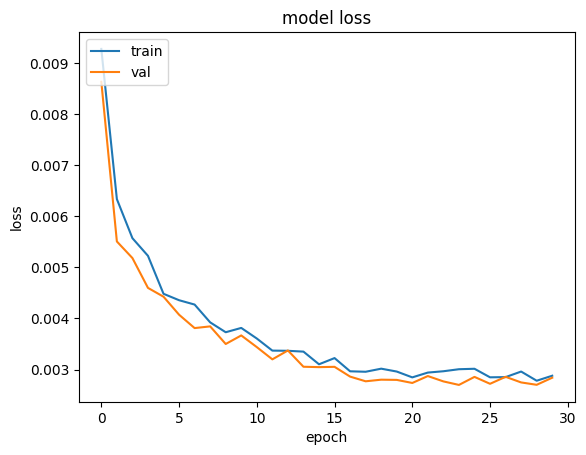

In [61]:
plt.plot(mmh.history['loss'])
plt.plot(mmh.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

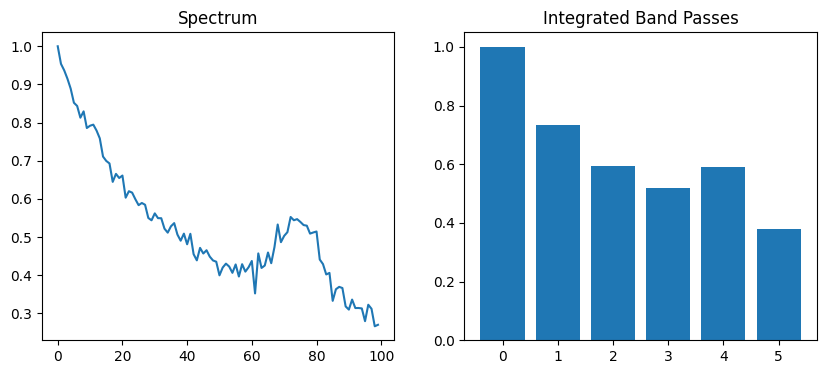

In [62]:
ii=70

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(spectra[ii])
plt.title('Spectrum')
plt.subplot(1, 2, 2)
plt.bar(range(len(integrals[ii])), integrals[ii])
plt.title('Integrated Band Passes')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_317']
Received: inputs=Tensor(shape=(1, 6))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_320']
Received: inputs=Tensor(shape=(1, 100, 1))
  warnings.warn(msg)


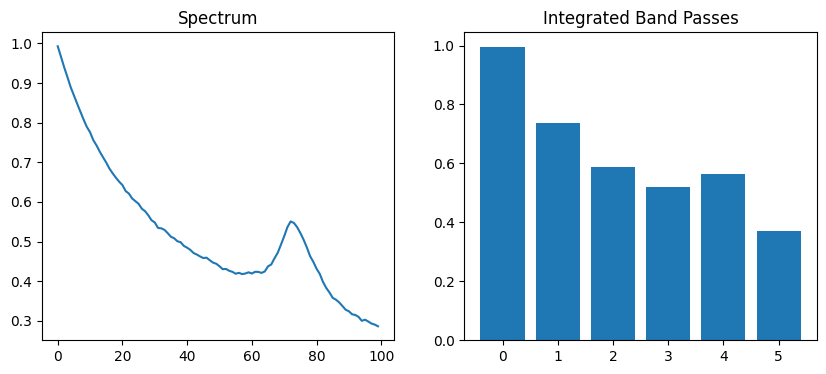

In [63]:
i_s = mmvae([[np.reshape(integrals[ii],(1,6)),np.reshape(spectra[ii],(1,100,1))]])
i = np.reshape(i_s[0].numpy(),(6,))
s = np.reshape(i_s[1].numpy(),(100,))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(s)
plt.title('Spectrum')
plt.subplot(1, 2, 2)
plt.bar(range(len(i)), i)
plt.title('Integrated Band Passes')
plt.show()

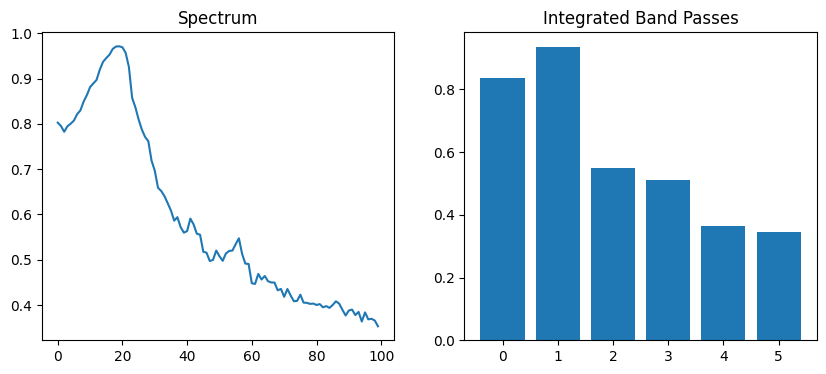

In [64]:
i_s = mmvae([(None, np.reshape(spectra[ii],(1,100,1)))])
i = np.reshape(i_s[0].numpy(),(6,))
s = np.reshape(i_s[1].numpy(),(100,))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(s)
plt.title('Spectrum')
plt.subplot(1, 2, 2)
plt.bar(range(len(i)), i)
plt.title('Integrated Band Passes')
plt.show()

In [68]:
spectra[ii]

array([1.        , 0.9539315 , 0.93691534, 0.9149584 , 0.88900506,
       0.8519915 , 0.84361154, 0.81282145, 0.8293653 , 0.7857597 ,
       0.79179245, 0.7945318 , 0.7790578 , 0.7585981 , 0.7109558 ,
       0.6994375 , 0.6928142 , 0.64457095, 0.66548866, 0.65469056,
       0.6611363 , 0.6031432 , 0.6200798 , 0.61636347, 0.5990276 ,
       0.5835368 , 0.5892004 , 0.58455235, 0.54995316, 0.54381025,
       0.56198996, 0.54945   , 0.54925513, 0.52185994, 0.51146114,
       0.5280622 , 0.53644115, 0.50646895, 0.49037224, 0.50886405,
       0.48097977, 0.5084222 , 0.4550499 , 0.43883055, 0.47151515,
       0.4567387 , 0.46528584, 0.44860387, 0.43853834, 0.43525603,
       0.39957246, 0.42002514, 0.43017513, 0.42259088, 0.40611714,
       0.4280626 , 0.39645925, 0.4287432 , 0.40929714, 0.420775  ,
       0.43715715, 0.35213256, 0.4569915 , 0.41894397, 0.42525095,
       0.4593543 , 0.431341  , 0.473678  , 0.5327526 , 0.48650452,
       0.50295466, 0.5127139 , 0.5524837 , 0.5439597 , 0.54687

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_317']
Received: inputs=Tensor(shape=(1, 6))
  warnings.warn(msg)


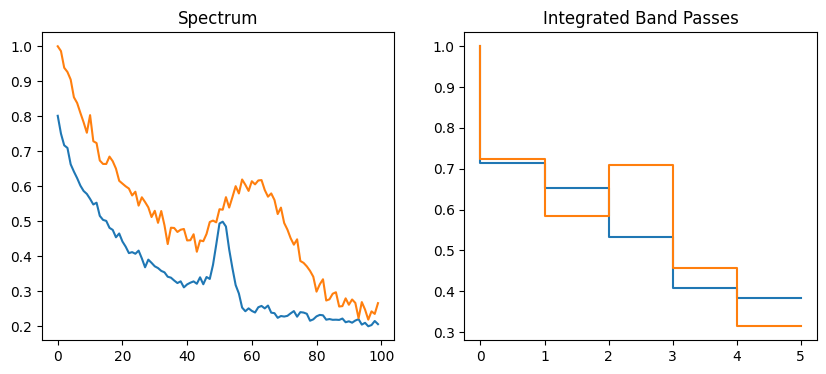

In [117]:
ii = 92

i_s = mmvae([(np.reshape(integrals[ii],(1,6)), None)])
i = np.reshape(i_s[0].numpy(),(6,))
s = np.reshape(i_s[1].numpy(),(100,))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(s)
plt.plot(spectra[ii])
plt.title('Spectrum')
plt.subplot(1, 2, 2)
plt.step(range(len(i)), i)
plt.step(range(len(i)), integrals[ii])
plt.title('Integrated Band Passes')
plt.show()

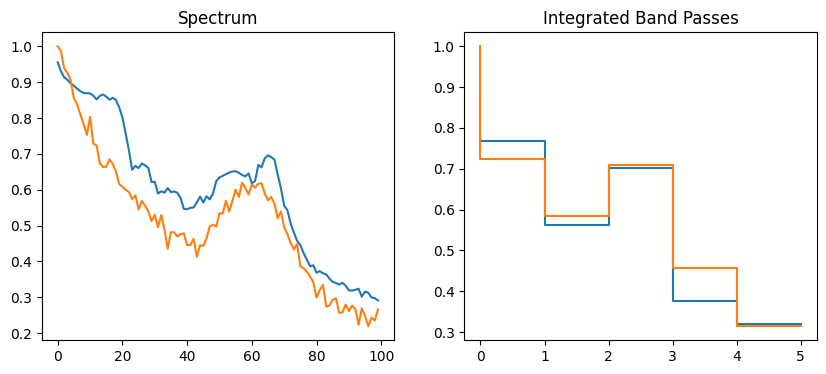

In [116]:
ii = 92

i_s = mmvae([(None, np.reshape(spectra[ii],(1,100,1)))])
i = np.reshape(i_s[0].numpy(),(6,))
s = np.reshape(i_s[1].numpy(),(100,))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(s)
plt.plot(spectra[ii])
plt.title('Spectrum')
plt.subplot(1, 2, 2)
plt.step(range(len(i)), i)
plt.step(range(len(i)), integrals[ii])
plt.title('Integrated Band Passes')
plt.show()